In [1]:
import copy

import numpy as np
import numpy.testing as npt
import pandas as pd
import pandas.testing as pdt
import pytest
from astropy import units as u

from tardis.plasma.assembly.base import (
    PlasmaSolverFactory,
    convert_species_to_multi_index,
)
from tardis.plasma.detailed_balance.rates import (
    #    UpsilonCMFGENSolver,
    ThermalCollisionalRateSolver,
    #    RadiativeRatesSolver,
    UpsilonRegemorterSolver,
)
from tardis.plasma.properties.atomic import YgData, YgInterpolator
from tardis.plasma.properties.continuum_processes import (
    CollDeexcRateCoeff,
    CollExcRateCoeff,
)
from tardis.plasma.properties.general import BetaElectron
from tardis.plasma.properties.partition_function import (
    ThermalLevelBoltzmannFactorLTE,
)
from tardis.plasma.properties.plasma_input import ContinuumInteractionSpecies
from tardis.plasma.radiation_field import planck_rad_field


def legacy_cmfgen_collision_rate_plasma_solver(nlte_atomic_dataset):
    atom_data = copy.deepcopy(nlte_atomic_dataset)
    # almost all settings are irrelevant for collisional strength data
    number_densities = pd.DataFrame({2: [1, 1]}).T
    temperatures = [10000, 20000] * u.K
    dilution_factor = np.array([1, 1])
    time_explosion = 5 * u.day
    dilute_planck_rad_field = planck_rad_field.DilutePlanckianRadiationField(
        temperatures, dilution_factor
    )
    plasma_solver_factory = PlasmaSolverFactory(atom_data)

    # plasma_solver_factory.continuum_interaction_species = ["He I"]
    plasma_solver_factory.line_interaction_type = "macroatom"
    plasma_solver_factory.prepare_factory([2])
    plasma_solver_factory.plasma_modules += [
        YgData,
        ContinuumInteractionSpecies,
        CollExcRateCoeff,
        CollDeexcRateCoeff,
        YgInterpolator,
        ThermalLevelBoltzmannFactorLTE,
        BetaElectron,
    ]
    species_mindex = convert_species_to_multi_index(["He I"])
    return plasma_solver_factory.assemble(
        number_densities,
        dilute_planck_rad_field,
        time_explosion,
        continuum_interaction_species=species_mindex,
    )



def test_thermal_collision_rates(
    legacy_cmfgen_collision_rate_plasma_solver,
    nlte_atomic_dataset,
    regression_data,
):
    radiative_transitions = nlte_atomic_dataset.lines.loc[
        (2, 0, slice(None), slice(None)), :
    ]

    collision_strengths = nlte_atomic_dataset.yg_data.loc[
        (2, 0, slice(None), slice(None)), :
    ]
    collision_strengths_temperatures = collision_strengths.columns.values * u.K

    therm_coll_rate_solver = ThermalCollisionalRateSolver(
        nlte_atomic_dataset.levels.loc[(2, 0, slice(None)), :],
        radiative_transitions,
        collision_strengths_temperatures,
        collision_strengths,
        collision_strengths_type="cmfgen",
        collisional_strength_approximation="regemorter",
    )
    coll_rates_coeff = therm_coll_rate_solver.solve([10000, 20000] * u.K)

    return coll_rates_coeff, legacy_cmfgen_collision_rate_plasma_solver.coll_exc_coeff, legacy_cmfgen_collision_rate_plasma_solver.coll_deexc_coeff


/home/afullard/tardis/tardis/__init__.py:20: UserWarning: Astropy is already imported externally. Astropy should be imported after TARDIS.
  warnings.warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
from tardis.io.atom_data.base import AtomData

nlte_atomic_data = AtomData.from_hdf("/home/afullard/tardis-regression-data/atom_data/nlte_atom_data/TestNLTE_He_Ti.h5")

legacy_solver = legacy_cmfgen_collision_rate_plasma_solver(nlte_atomic_data)

In [3]:
rates, legacy_exc_rates, legacy_deexc_rates = test_thermal_collision_rates(legacy_solver, nlte_atomic_data, None)

<Axes: xlabel='atomic_number,ion_number,level_number_source,level_number_destination'>

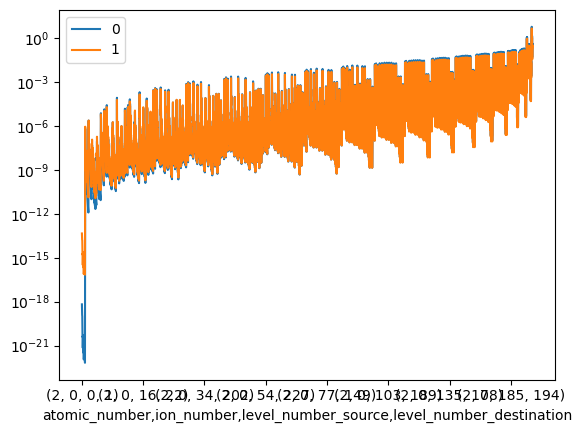

In [6]:
rates[:3681].plot(logy=True)

<Axes: xlabel='atomic_number,ion_number,level_number_lower,level_number_upper'>

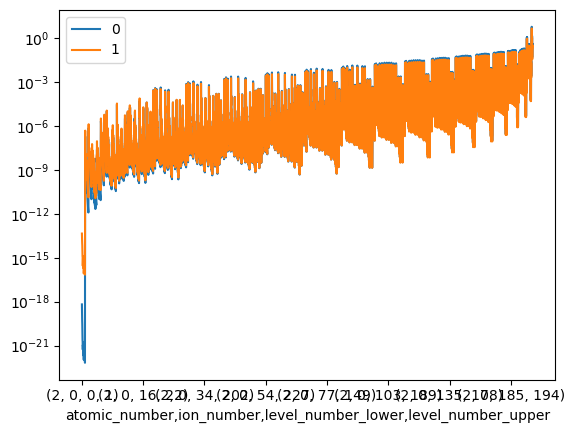

In [5]:
legacy_exc_rates.plot(logy=True)